# Imports

In [1]:
import random

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

from src.utils import metrics
from src.utils import data_loader as d
from src.utils import models

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load Data

In [2]:
islas_dfs = d.data_loader()

Fecha inicio: 2020-01-01 00:00:00
Fecha fin: 2024-06-30 00:00:00
Total number of days: 1642 days 00:00:00


# Data transform

In [3]:
# Extract energy demand values and reshape for scaling
energy = islas_dfs['Tenerife']['OBS_VALUE'].values.reshape(-1,1) # data['energy'].values.reshape(-1, 1)

# Scale the data to [0,1] for easier training
scaler = MinMaxScaler()
energy_scaled = scaler.fit_transform(energy)

# ======= 2. Train-Validation-Test Split =======
train_size = 1460  # First 4 years for training/validation
val_size = int(0.2 * train_size)  # 20% of training data for validation
window_size = 30 # 30  # Window size for sequences

# Split into training, validation, and test sets
train_data = energy_scaled[:train_size - val_size]
val_data = energy_scaled[train_size - val_size:train_size]
test_data = energy_scaled[train_size - window_size:]

# Utility function: create input-output sequences using a sliding window
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        target = data[i + window_size]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Create sequences for training and validation
train_sequences, train_targets = create_sequences(train_data, window_size)
val_sequences, val_targets = create_sequences(val_data, window_size)

# Convert to PyTorch tensors
train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)
val_sequences = torch.tensor(val_sequences, dtype=torch.float32)
val_targets = torch.tensor(val_targets, dtype=torch.float32)

# Model training and validation

Epoch [100/2866], Train Loss: 0.0103, Val Loss: 0.0123
Epoch [200/2866], Train Loss: 0.0096, Val Loss: 0.0121
Epoch [300/2866], Train Loss: 0.0057, Val Loss: 0.0073
Epoch [400/2866], Train Loss: 0.0024, Val Loss: 0.0032
Epoch [500/2866], Train Loss: 0.0023, Val Loss: 0.0030
Epoch [600/2866], Train Loss: 0.0023, Val Loss: 0.0030
Early stopping!


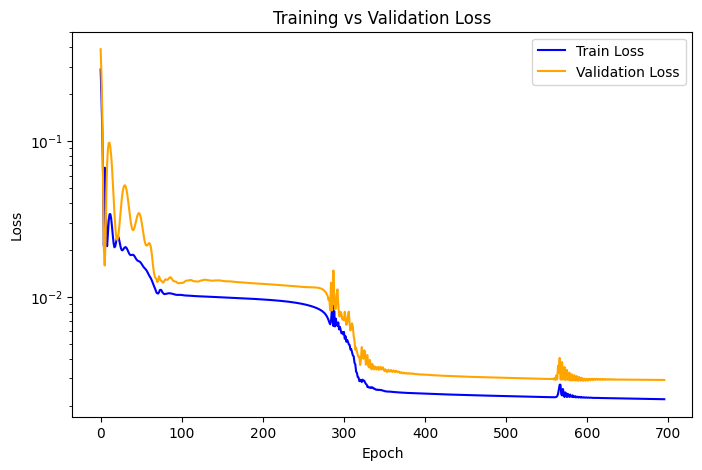

In [4]:
model = models.LSTMModel(hidden_size=32) # --> 0.71
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)


num_epochs = 2866 # best without overfitting
train_losses, val_losses = [], []
early_stopping_patience = 100
best_val_loss = float('inf')
stopping_counter = 0
early_stopping = True


for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_sequences)
    train_loss = criterion(output, train_targets)
    train_loss.backward()
    optimizer.step()
    
    # Validation step
    model.eval()
    with torch.no_grad():
        val_output = model(val_sequences)
        val_loss = criterion(val_output, val_targets)
    
    
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        stopping_counter = 0
    else:
        stopping_counter += 1

    if early_stopping and stopping_counter >= early_stopping_patience:
        print('Early stopping!')
        break

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# ======= 5. Plot Training vs Validation Loss =======
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


# Prediction

In [5]:
test_sequences, test_targets = create_sequences(test_data, window_size)
test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
test_targets = torch.tensor(test_targets, dtype=torch.float32)

online_predictions = []
actual_values = []

online_optimizer = optim.Adam(model.parameters(), lr=1e-6)

for i in range(len(test_sequences)):
    x = test_sequences[i].unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        pred = model(x)
    online_predictions.append(pred.item())
    actual_values.append(test_targets[i].item())

    # Online learning step
    model.train()
    online_optimizer.zero_grad()
    pred_online = model(x)
    loss_online = criterion(pred_online, test_targets[i].unsqueeze(0))
    loss_online.backward()
    online_optimizer.step()

# Inverse transform
online_predictions_inv = scaler.inverse_transform(np.array(online_predictions).reshape(-1, 1)).flatten()
actual_values_inv = scaler.inverse_transform(np.array(actual_values).reshape(-1, 1)).flatten()

metrics_result = metrics.all_metrics(actual_values_inv, online_predictions_inv)
print("Evaluation Metrics:")
for metric, value in metrics_result.items():
    print(f"{metric}: {value:.4f}")



Evaluation Metrics:
MAE: 139.0418
MSE: 50454.7148
RMSE: 224.6213
R2: 0.7078
MAPE: 0.0162
sMAPE: 0.0161


# Animation

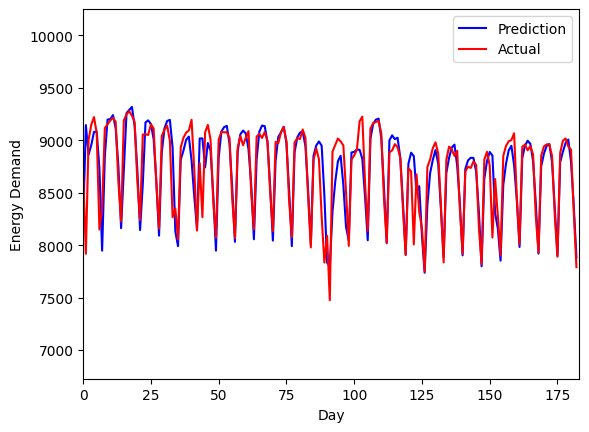

In [6]:
fig, ax = plt.subplots()
line_pred, = ax.plot([], [], label='Prediction', color='blue')
line_act, = ax.plot([], [], label='Actual', color='red')
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Energy Demand')
ax.set_xlim(0, len(online_predictions_inv))
ax.set_ylim(min(min(online_predictions_inv), min(actual_values_inv)) * 0.9, 
            max(max(online_predictions_inv), max(actual_values_inv)) * 1.1)

def init():
    line_pred.set_data([], [])
    line_act.set_data([], [])
    return line_pred, line_act

def animate(i):
    x = np.arange(i + 1)
    y_pred = online_predictions_inv[:i + 1]
    y_act = actual_values_inv[:i + 1]
    line_pred.set_data(x, y_pred)
    line_act.set_data(x, y_act)
    return line_pred, line_act

ani = animation.FuncAnimation(fig, animate, frames=len(online_predictions_inv),
                              init_func=init, interval=50, blit=True)

ani.save(f'../results/lstm_prediction.mp4', writer='ffmpeg')

plt.show()